In [52]:
import tensorflow as tf
import os
import cv2
import imghdr
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [2]:
#Setting GPU memo Growth

gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

## Select Images 

In [3]:
#unzip the file

zip_path = './datasets.zip'
zip_ref = zipfile.ZipFile(zip_path,'r')
zip_ref.extractall('./datasets')
zip_ref.close()


In [4]:
#Generate paths

base_path = '/content/datasets/datasets'
cats = os.path.join(base_path,'cats')
dogs = os.path.join(base_path,'dogs')

cat_filenames = os.listdir(cats)
dog_filenames = os.listdir(dogs)

In [5]:
#Remove images which are not in image_types list
image_types = ['jpeg','jpg','bmp','png']

for images_clases in os.listdir(base_path):
  for image in os.listdir(os.path.join(base_path,images_clases)):
    image_path = os.path.join(base_path,images_clases,image)
    try:
      imgs=cv2.imread(image_path)
      fn  =imghdr.what(image_path)
      if fn not in image_types:
        print(f"Image type not in list,image:{image_path}")
        os.remove(image_path)
    except Exception as e:
      print(f"Issue with image:{image_path}")


Image type not in list,image:/content/datasets/datasets/dogs/German-shepherd.jpg
Image type not in list,image:/content/datasets/datasets/dogs/2022-05-06_10_Easy_Pieces_to_Liven_Up_Your_Dog-s_Dinner_AdobeStock_328836752.jpg
Image type not in list,image:/content/datasets/datasets/dogs/skynews-dogs-research-study_5498490.jpg
Image type not in list,image:/content/datasets/datasets/dogs/skynews-dog-nose-stufy-small_5846595.jpg
Image type not in list,image:/content/datasets/datasets/dogs/800px-French_Bulldog_with_puppies.jpg
Image type not in list,image:/content/datasets/datasets/cats/Abyssinian-sorrel.jpg
Image type not in list,image:/content/datasets/datasets/cats/95575-AmazonPets_Mobile-CatStore-EN_copy.jpg
Image type not in list,image:/content/datasets/datasets/cats/1200px-Cat_November_2010-1a.jpg
Image type not in list,image:/content/datasets/datasets/cats/p07ryyyj.jpg
Image type not in list,image:/content/datasets/datasets/cats/black-cat-back.jpg
Image type not in list,image:/content/d

## Read Images

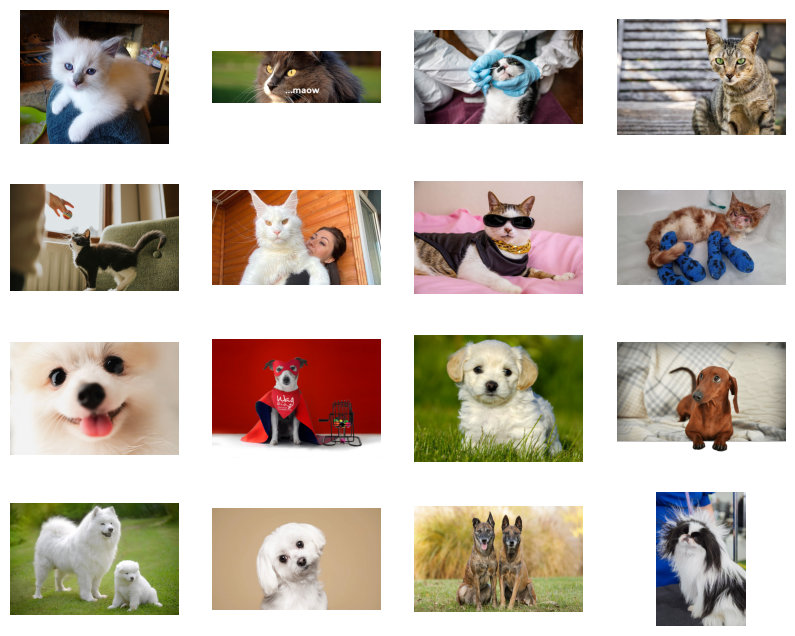

In [68]:
nrows=4
ncols=4



plt.figure(figsize=(10,8))

image_index=20

cat_iamge_list = [os.path.join(cats,fn) for fn in cat_filenames[image_index-8:image_index]]
dog_image_list = [os.path.join(dogs,fn) for fn in dog_filenames[image_index-8:image_index]]

for inx,path in enumerate(cat_iamge_list+dog_image_list):
  subplots = plt.subplot(nrows,ncols,inx+1)
  subplots.axis('off')

  imgs = img.imread(path)
  plt.imshow(imgs)
  

plt.show()

## Train/Test/Validation splits

In [41]:
# using data aurgumentation to train data

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
])

data = tf.keras.utils.image_dataset_from_directory(base_path,batch_size=8)

train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

# Split the dataset into train, validation, and test sets

train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

# Apply data augmentation to the training data


train_data_aurgumented = train_data.map(lambda x,y: (data_augmentation(x,training=True),y))



# Apply scaling to the validation and test data
train_data_aurgumented = train_data_aurgumented.map(lambda x,y:(tf.cast(x/255,tf.float32),y))
val_data = val_data.map(lambda x,y:(tf.cast(x/255,tf.float32),y))
test_data = test_data.map(lambda x,y:(tf.cast(x/255,tf.float32),y))


Found 175 files belonging to 2 classes.


In [69]:
# Get the class labels
class_names = data.class_names
print(class_names)

['cats', 'dogs']


In [36]:
train_data_aurgumented


<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Model 

In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(16,(3,3),1,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32,(3,3),1,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64,(3,3),1,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])



## Model compile

In [43]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

# Get the summary

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 30, 30, 32)     

## Model train 

In [28]:
log_dir = './logs'
os.makedirs(log_dir)

In [44]:
callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [45]:
history =model.fit(train_data_aurgumented,epochs=30,validation_data=val_data,callbacks=[callback])

Epoch 1/30
15/15 [==============================] - 25s 1s/step - loss: 0.7716 - accuracy: 0.4583 - val_loss: 0.6946 - val_accuracy: 0.4688
Epoch 2/30
15/15 [==============================] - 19s 1s/step - loss: 0.7267 - accuracy: 0.5417 - val_loss: 0.6985 - val_accuracy: 0.3750
Epoch 3/30
15/15 [==============================] - 24s 1s/step - loss: 0.6989 - accuracy: 0.5250 - val_loss: 0.6885 - val_accuracy: 0.5312
Epoch 4/30
15/15 [==============================] - 24s 1s/step - loss: 0.6980 - accuracy: 0.5167 - val_loss: 0.6871 - val_accuracy: 0.5625
Epoch 5/30
15/15 [==============================] - 24s 1s/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.7283 - val_accuracy: 0.4688
Epoch 6/30
15/15 [==============================] - 19s 1s/step - loss: 0.6810 - accuracy: 0.5750 - val_loss: 0.5887 - val_accuracy: 0.6562
Epoch 7/30
15/15 [==============================] - 23s 1s/step - loss: 0.6555 - accuracy: 0.6000 - val_loss: 0.6903 - val_accuracy: 0.5312
Epoch 8/30
15/15 [==

## Plot accuracy/loss

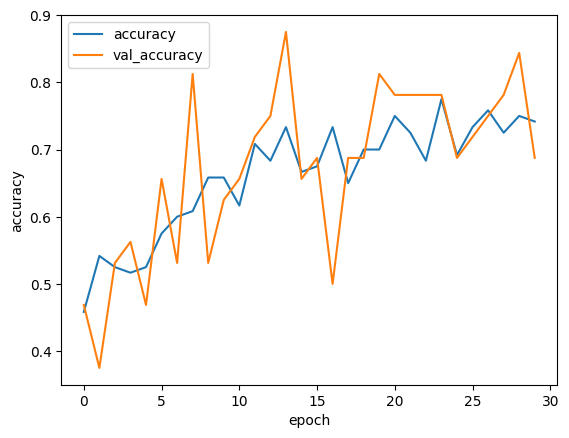

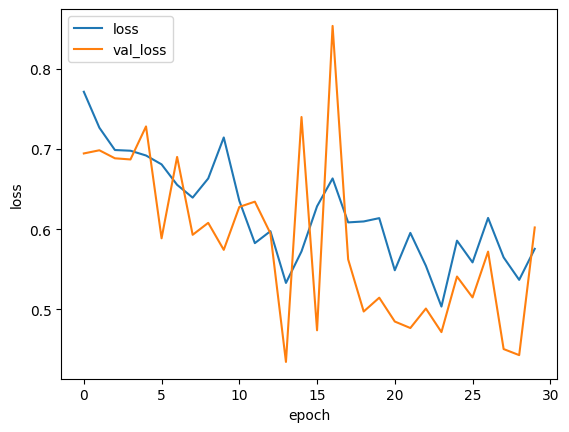

In [51]:
def plot_grap(histroy,string):
  plt.figure()
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('epoch')
  plt.ylabel(string)
  plt.legend([string,'val_'+string],loc=2)
  plt.show()

plot_grap(history,'accuracy')
plot_grap(history,'loss')

## Model Eveluation

In [53]:
precision = Precision()
recall    = Recall()
accuracy = BinaryAccuracy()

In [55]:
for batch in test_data.as_numpy_iterator():
  x,y =batch
  yhat = model.predict(x)
  precision.update_state(y,yhat)
  recall.update_state(y,yhat)
  accuracy.update_state(y,yhat)

1/1 [==============================] - 0s 154ms/step


In [58]:
print(f'precision:{precision.result().numpy()}')
print(f'recall:{recall.result().numpy()}')
print(f'accuracy:{accuracy.result().numpy()}')

precision:1.0
recall:0.800000011920929
accuracy:0.875


## Test Model

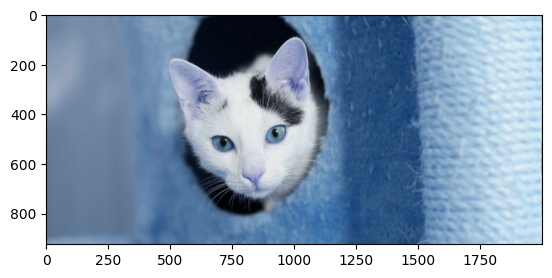

In [59]:
test_im = cv2.imread('/content/cat-home-441939.jpg')
plt.imshow(test_im)
plt.show()

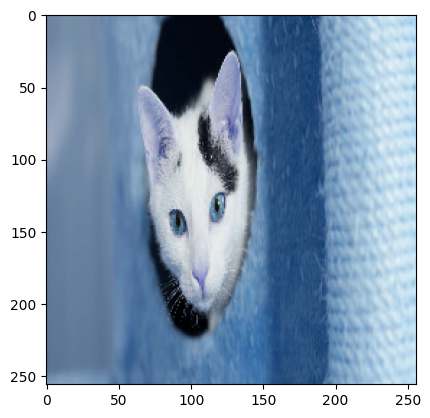

In [61]:
#resize image

resize_img = tf.image.resize(test_im,(256,256))
plt.imshow(resize_img.numpy().astype(int))
plt.show()

In [63]:
yhat = model.predict(np.expand_dims(resize_img/255.0,axis=0))
yhat

1/1 [==============================] - 0s 126ms/step


array([[0.31544352]], dtype=float32)

In [70]:
if yhat > 0.5:
  print(f'Predicated image is a dog')
else:
  print(f'Predicated image is a cat')

Predicated image is a cat


## Model save

In [71]:
model.save(os.path.join('model_save','imageclassifirer.h5'))